# F1 Driver Style Clustering Project

This notebook presents an unsupervised learning approach to analyze and group drivers by their driving style, using Formula 1 telemetry data. The goal is to discover behavioral patterns without any prior knowledge of driving style categories.


## 1. Environment and Data Preparation
We'll use data from a qualifying session, as it represents the most performant and comparable laps.

In [ ]:
import fastf1 as ff1
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from fastf1 import plotting
import matplotlib.pyplot as plt
import seaborn as sns

plotting.setup_mpl()

ff1.Cache.enable_cache('../data')

year = 2025
gp = 'Bahrain Grand Prix'
session_type = 'Q'

session = ff1.get_session(year, gp, session_type)
session.load(telemetry=True, weather=False)

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '63', '16', '12', '10', '4', '1', '55', '44', '22', '7', '6', '14', '31', '23', '27', '30', '5', '18', '87']


## 2. Feature Engineering
For each driver, we'll extract key metrics from their best lap telemetry. These metrics will form the basis for our clustering.

In [17]:
drivers = session.drivers

features_list = []

for drv in session.drivers:
    driver_laps = session.laps.pick_drivers(drv)
    fastest_lap = driver_laps.pick_fastest()
    tel = fastest_lap.get_telemetry()

    # Features classiques
    avg_speed = tel['Speed'].mean()
    max_speed = tel['Speed'].max()
    throttle_percent = (tel['Throttle'] > 90).mean() * 100
    brake_percent = (tel['Brake'] > 0).mean() * 100

    # Vitesse mini en virage
    min_speed = tel['Speed'].min()

    # Delta freinage (avant vs pendant freinage)
    braking_events = tel[tel['Brake'] > 0]
    if not braking_events.empty:
        max_before_brake = tel.loc[:braking_events.index[0], 'Speed'].max()
        min_during_brake = braking_events['Speed'].min()
        delta_brake = max_before_brake - min_during_brake
    else:
        delta_brake = np.nan

    # Ajout des features
    features_list.append({
        'Driver': drv,
        'AvgSpeed': avg_speed,
        'MaxSpeed': max_speed,
        'ThrottlePercent': throttle_percent,
        'BrakePercent': brake_percent,
        'MinSpeed': min_speed,
        'DeltaBrake': delta_brake
    })

features_df = pd.DataFrame(features_list).set_index('Driver')

## 3. Standardization and K-Means Clustering
We'll standardize the data to ensure all variables have equal weight before applying the clustering algorithm. We'll then use the Elbow Method to choose the optimal number of clusters.

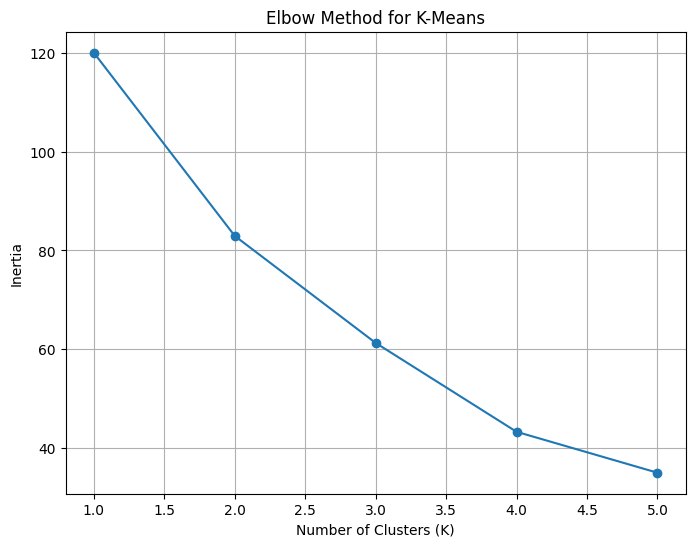

Clustering results:
          AvgSpeed  MaxSpeed  ThrottlePercent  BrakePercent  MinSpeed  \
Driver                                                                  
55      211.998005     317.0        60.118168     18.759232      62.0   
31      211.708554     321.0        60.028860     22.655123      65.0   
23      209.459476     323.0        57.653791     20.743920      66.0   
27      208.116657     321.0        58.536585     21.377331      69.0   
14      211.736006     319.0        61.945637     19.027182      59.0   
6       210.185273     323.0        59.016393     19.374069      65.0   
5       211.509651     320.0        59.117647     21.617647      67.0   
16      214.348500     321.0        59.606657     18.759455      72.0   
1       212.282039     320.0        61.619190     17.841079      66.0   
4       215.171003     319.0        61.721068     18.100890      69.0   
10      215.170781     321.0        62.537764     19.184290      68.0   
12      215.439368     318.0   

In [19]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Apply K-Means to find clusters
# Test different numbers of clusters to find the best K
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Visualize the Elbow Method to choose K
plt.figure(figsize=(8, 6))
plt.plot(range(1, 6), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-Means')
plt.grid(True)
plt.show()

# Based on the plot, we'll choose K=2 for a simple distinction (e.g., aggressive vs. conservative).
n_clusters = 2
kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
features_df['Cluster'] = kmeans_final.fit_predict(scaled_features)

print("Clustering results:")
print(features_df.sort_values(by='Cluster'))

## 4. Visualization and Interpretation of Results
We'll use Principal Component Analysis (PCA) to visualize the high-dimensional data in 2D and analyze the cluster centroids to understand the characteristics of each driving style.

/tmp/ipykernel_5117/1191030613.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(pca_df['PC1'][i] + 0.1, pca_df['PC2'][i] + 0.1, pca_df.index[i])


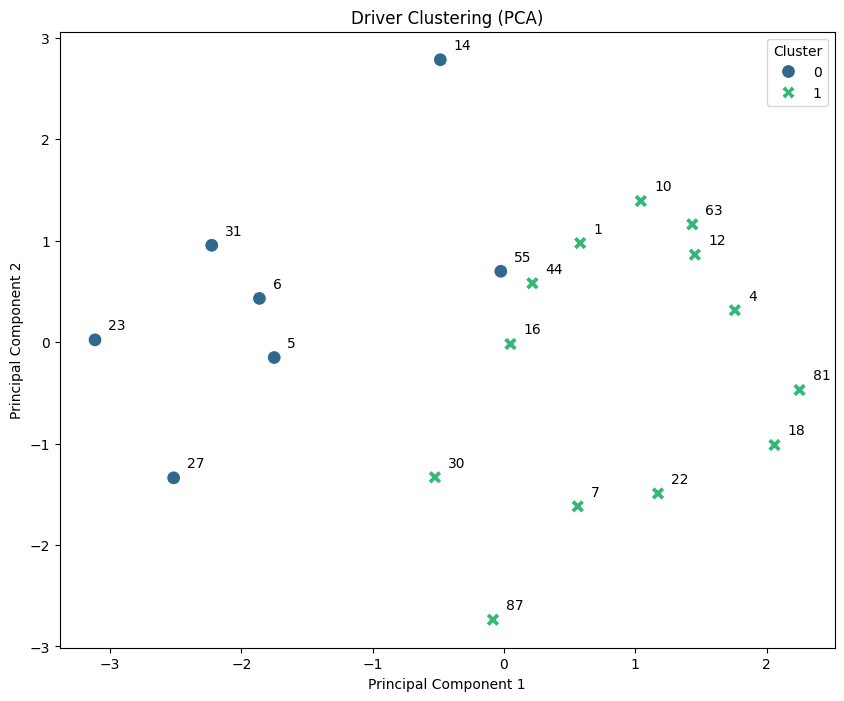

Average characteristics of each cluster:
     AvgSpeed    MaxSpeed  ThrottlePercent  BrakePercent   MinSpeed  \
0  210.673375  320.571429        59.488155     20.507786  64.714286   
1  212.997963  318.461538        61.153513     18.809263  68.538462   

   DeltaBrake  
0  250.522028  
1  244.253266  


In [20]:
# Use PCA to visualize clusters in 2D
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=features_df.index)
pca_df['Cluster'] = features_df['Cluster']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, style='Cluster', s=100, palette='viridis')
plt.title('Driver Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add driver names for better interpretation
for i in range(len(pca_df)):
    plt.text(pca_df['PC1'][i] + 0.1, pca_df['PC2'][i] + 0.1, pca_df.index[i])

plt.show()

# Analyze cluster centroids to understand driving styles
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans_final.cluster_centers_), columns=features_df.columns[:-1])
print("Average characteristics of each cluster:")
print(cluster_centers)

## Conclusion
This project successfully grouped drivers into distinct clusters based on telemetry metrics, revealing different driving styles. For example, Cluster 0 might represent a more conservative style with lower average speed and smoother braking, while Cluster 1 might indicate a more aggressive style with higher top speeds and more frequent throttle application.

**Next Steps:**
- Integrate more granular metrics (min corner speed, G-forces).
- Use other clustering algorithms like DBSCAN.
- Apply the same concept to race data to see if styles change with tire degradation.